# Introduction to the FEM Module

We will implement a simple fem problem to test how the FEM module works. We first implement the Laplace equation
$$
  - \Delta u = 1, \qquad x \in (-1,1)^2,  \qquad u = 0 \quad \text{on the boundary}
$$

In [1]:
using PyPlot, Compose
using LujiaLt.FEM


INFO: Precompiling module PyPlot...
INFO: Precompiling module Compose...


In [2]:
# implement a radial mesh 

# we only need to produce the point
# and let the delaunay triangulation create the elements
function Xsquare(N)
    x = linspace(-1, 1, N)
    o = ones(N)
    x, y = (x * o')[:], (o * x')[:]
    return [x'; y']
end

# create the nodes for the triangulation
Ntest = 12
X = Xsquare(Ntest)
# plot(X[1,:], X[2,:], "b.");

# we also need something that will give us the 
# interior (free) nodes
free_nodes(X) = find( maxabs(X, 1) .< 1-1e-10 );


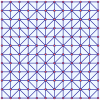

In [3]:
# create a triangulation
tri = Triangulation(X)
FEM.plot(tri; width=10cm, xradius=0.02, lwidth=0.5);

In [4]:
# check how many triangles we have
println("number of triangles = ", nT(tri))
println("we should have ", 2 * (Ntest-1)^2)
if nT(tri) == 2 * (Ntest-1)^2
    println("""=> this is great: it means that no thin triangles are 
               created on the boundary due to numerical round-off!""")
else
    println("something went wrong: please file an issue!")
end

number of triangles = 242
we should have 242
=> this is great: it means that no thin triangles are 
created on the boundary due to numerical round-off!


In [5]:

# assembly of P1-laplacian
function P1_laplacian(tri)
    # initialise triplet format
    I = Int[]; J = Int[]; V = Float64[]
    # initialise r-h-s
    F = zeros(nX(tri))
    # assembly loop
    for el in elements(tri)
        # element stiffness matrix (el.B is the gradient operator)
        Ael = el.vol * el.B * el.B'
        # write into global stiffness matrix
        for i = 1:3, j = 1:3
            push!(I, el.t[i]); push!(J, el.t[j]); push!(V, Ael[i,j])
        end
        # r-h-s  (force ≡ 1)
        F[el.t] = el.vol / 3
    end
    return sparse(I, J, V), F
end



P1_laplacian (generic function with 1 method)

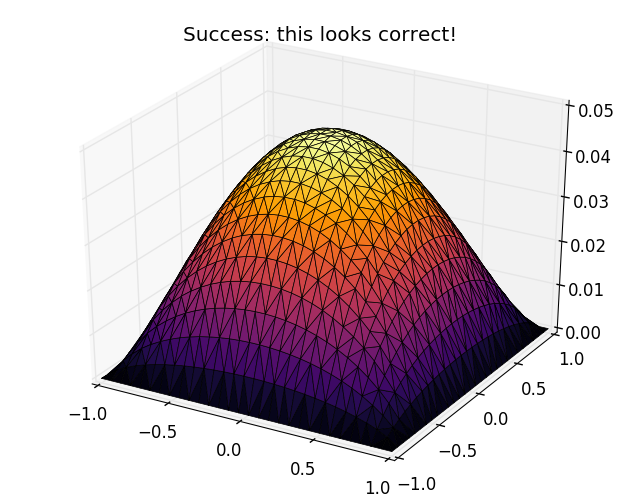

PyObject <matplotlib.text.Text object at 0x33a9c1790>

In [97]:
# solve
tri = Triangulation(Xsquare(30))
A, b = P1_laplacian(tri)
u = zeros(nX(tri))
Ifree = free_nodes(tri.X)
u[Ifree] = A[Ifree, Ifree] \ b[Ifree];
# … and plot
PyPlot.plot_trisurf(tri.X[1,:][:], tri.X[2,:][:], u,
                    triangles=tri.T'-1, 
                    cmap=ColorMap("inferno"), linewidth=0.5)
title("Success: this looks correct!")

## Second Example: Nonlinear problem

$$
   \arg\min_{W^{1,p}_0} \int_{\Omega} (1 + |\nabla u|^2)^{p/2} dx
$$
We solve this with a pre-conditioned CG method via `Optim.jl`.

In [88]:
# specify the energy 
W(F, p) = (0.01 + 1/p * sumabs2(F))^(p/2)
dW(F, p) = (0.01 + 1/p * sumabs2(F))^(p/2-1) * F

# u : dof vector
# tri : triangulation
# p : p parameter for p-laplacian
# u0 : dirichlet condition
# Ifree : free nodes
function plaplacian(u, tri, p, u0, Ifree)
    @assert 1 < p < Inf 
    v = copy(u0)
    v[Ifree] = u
    E = 0.0
    dE = zeros(nX(tri))
    for el in elements(tri)
        Du = el.B' * v[el.t]
        E += el.vol * (W(Du, p) - mean(v[el.t]))
        dE[el.t] += el.vol * (el.B * dW(Du, p) - ones(length(el.t))/length(el.t))
    end
    return E, dE[Ifree]
end



plaplacian (generic function with 1 method)

In [89]:
# finite-difference test to make sure this is correctly implemented
import LujiaLt.Testing
tri = Triangulation(Xsquare(8))
A, b = P1_laplacian(tri)
u0 = zeros(nX(tri))
Ifree = free_nodes(tri.X)
p = 4
F = u -> plaplacian(u, tri, p, u0, Ifree)[1]
dF = u -> plaplacian(u, tri, p, u0, Ifree)[2]
LujiaLt.Testing.fdtest(F, dF, 0.1 * rand(length(Ifree)))


---------|----------- 
    h    | error 
---------|----------- 
 1.0e-03 | 2.42e-04  
 1.0e-04 | 2.41e-05  
 1.0e-05 | 2.41e-06  
 1.0e-06 | 2.41e-07  
 1.0e-07 | 2.39e-08  
 1.0e-08 | 3.61e-09  
 1.0e-09 | 3.13e-08  
 1.0e-10 | 3.52e-07  
---------|----------- 
passed


true

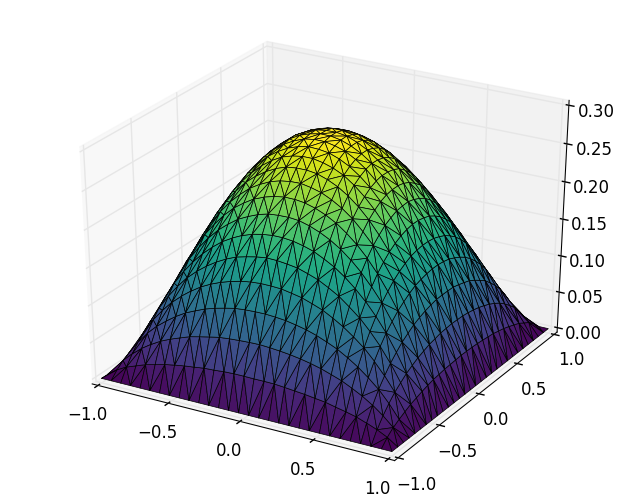

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x33a52f390>

In [96]:
#
import Optim
tri = Triangulation(Xsquare(30))
A, b = P1_laplacian(tri)
u0 = zeros(nX(tri))
Ifree = free_nodes(tri.X)
p = 5

E, dE = plaplacian(u0[Ifree], tri, p, u0, Ifree)

# unfortunately, Optim.jl doesn't allow the type of
# objective we just implemented, we need to do a
# silly hack - some work to do to fix this!
F = u -> plaplacian(u, tri, p, u0, Ifree)[1]
dF = u -> plaplacian(u, tri, p, u0, Ifree)[2]
dF! = (u, g) -> copy!( g, dF(u) )
obj = Optim.DifferentiableFunction(F, dF!)

# call Optim
results = Optim.optimize(obj, u0[Ifree], 
                    method = Optim.ConjugateGradient(P = A[Ifree, Ifree]),
                    ftol = 1e-32, grtol = 1e-8)
u = copy(u0);
u[Ifree] = results.minimum

# plot result
PyPlot.plot_trisurf(tri.X[1,:][:], tri.X[2,:][:], u,
                    triangles=tri.T'-1, 
                    cmap=ColorMap("viridis"), linewidth=0.5)
